<a href="https://colab.research.google.com/github/velasale/AI534-Machine-Learning/blob/main/velasale_IA1_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI534 Implementation 1###
**Deadline**: Sunday, Oct. 13, by 11:59pm

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs (the codeblock at the end of the notebook should automatically produce the pdf file).

In this assignment, we will implement and experiment linear regression to predict the price of a house based on features describing the house, using the housing data that you have explored in the warm up assignment.

We will implement two versions, one using the closed-form solution, and one using gradient descent.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that your TA can understand what you are doing and why.

First lets import the necessary packages.

In [ ]:
!pip install nbconvert > /dev/null 2>&1
!pip install pdfkit > /dev/null 2>&1
!apt-get install -y wkhtmltopdf > /dev/null 2>&1
import os
import pdfkit
import contextlib
import sys
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# add more imports if necessary

# Part 0: (5 pts) data and preprocessing

---

On canvas, we have provided two different data files for this assignment: ia1_train.csv (for training) and ia1_val.csv(for validation). Download them and upload them to your google drive. Then mount the google drive from your google colab notebook:


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/AI534/ia1_train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = '/content/gdrive/My Drive/AI534/ia1_val.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Now load the training and validation data.

In [ ]:
# Training data
raw_training_data = pd.read_csv(train_path)
raw_training_data
# Validation data
raw_validation_data = pd.read_csv(val_path)
raw_validation_data

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,3211200460,8/6/2014,4,1.00,1520,9800,1.5,0,0,4,...,1520,0,1971,0,98034,47.7303,-122.236,1540,7700,3.8900
1,4124000320,3/16/2015,3,2.25,1800,15903,1.0,0,0,3,...,1340,460,1986,0,98038,47.3813,-122.043,2000,15233,3.3562
2,7129302800,12/12/2014,3,1.50,1780,5000,1.0,0,4,4,...,1030,750,1958,0,98118,47.5168,-122.256,1780,7500,4.2000
3,1392800035,6/18/2014,2,1.00,1240,6400,1.0,0,1,4,...,1060,180,1938,0,98126,47.5493,-122.377,1240,6400,5.5900
4,2154900040,10/30/2014,3,2.25,2190,8834,1.0,0,0,3,...,1390,800,1987,0,98001,47.2633,-122.244,1490,8766,1.9425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,5132000140,1/20/2015,6,1.00,1370,5080,1.5,0,0,3,...,1120,250,1931,0,98106,47.5238,-122.350,1020,5080,4.1500
1996,6624010170,5/8/2014,3,1.75,1390,7399,1.0,0,0,4,...,1390,0,1975,0,98031,47.4183,-122.182,1460,7800,2.4600
1997,1853080840,2/11/2015,5,3.50,3700,7055,2.0,0,0,3,...,3700,0,2014,0,98074,47.5929,-122.057,3170,6527,8.8995
1998,2767601311,10/24/2014,3,2.50,1260,1102,3.0,0,0,3,...,1260,0,2007,0,98107,47.6750,-122.387,1320,2500,4.4500


Perform the following preprocessing steps.
1. remove the *ID* column from both training and validation data
2. change *date* into 3 numerical features *day*, *month* and *year*, like in the warm up exercise
3. The feature *yr_renovated* is set to 0 if the house has not been renovated. This creates an inconsistent meaning to the numerical values. Replace it with a new feature called *age_since_renovated*:

>if *yr_renovate* != 0
>> *age_since_renovated* = *year* - *yr\_renovated*  

>otherwise
>> *age\_since\_renovated = year - yr\_built*

4. Normalize all the feautres using z-score normalization based on the training data. Do not normalize *price* as it is the target.
To normalize a feature *x* using z-score normalization, the fomula is

>$z=\frac{x-\mu}{\sigma}$

where $\mu$ and $\sigma$ are the mean and standard deviation of $x$ respectively. The normalized feature will have zero mean and unit standard deviation. Note that you should estimate $\mu$ and $\sigma$ for each feature only using the training data and use the same $\mu$ and $\sigma$ to normalize the features for both training and validation data.




In [ ]:
# 1 - Removing ID column
training_data_without_id = raw_training_data.drop(columns=['id'])
validation_data_without_id = raw_validation_data.drop(columns=['id'])

# 2 - Change date into 3 numerical features
def fix_date(df):
  """Changes the format mm/dd/yy into three columns 'SaleDay', 'SaleMonth', and 'SaleYear"""
  df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
  # extract month, day, and year into separate columns
  df['SaleMonth'] = df['date'].dt.month
  df['SaleDay'] = df['date'].dt.day
  df['SaleYear'] = df['date'].dt.year
  # drop the original date column
  df = df.drop(columns=['date'])
  return df

training_data_without_id = fix_date(training_data_without_id)
validation_data_without_id = fix_date(validation_data_without_id)


# 3 - Age since renovation
def fix_yr_renovation(df):
  """Replaces the feature 'yr_renovated' with a new feature 'age_since_renovated'"""
  # Apply condition
  df['age_since_renovated'] = df.apply(
                                       lambda x: x['SaleYear'] - x['yr_renovated']
                                       if x['yr_renovated'] != 0
                                       else x['SaleYear'] - x['yr_built'],
                                       axis=1)
  cols = len(df.columns)
  #print('Training columns', cols)
  # move price column to the end
  df.insert(cols-1, 'price', df.pop('price'))
  # remove feature 'yr_renovated' and replace it with 'age_since_renovated'
  column_index = df.columns.get_loc('yr_renovated')
  df.pop('yr_renovated')
  df.insert(column_index, 'age_since_renovated', df.pop('age_since_renovated'))
  df.iloc[:,-20:]     # simply to display the last 20 columns and double check
  return df

training_data_without_id = fix_yr_renovation(training_data_without_id)
validation_data_without_id = fix_yr_renovation(validation_data_without_id)


# 4 - Feature Z-Score Normalization
def zscore_normalize(training_df, validation_df):
  """Aplies z-score to training dataset and validation dataset
     Heads Up: a. Mean and STD parameters from training dataset are used to normalize both
                  training AND validation dataset
               b. Only features are normalized, and target 'price' is not.
  """
  normalized_training_df = training_df.copy().astype(float) # to avoid warnings from changing dtype (from int to float)
  normalized_validation_df = validation_df.copy().astype(float) # to avoid warnings from changing dtype (from int to float)
  cols = len(training_df.columns)
  print('\nNumber of features', cols-1)

  for i in range(cols-1):
    training_data_column = training_df.iloc[:,i]
    validation_data_column = validation_df.iloc[:,i]
    # Obtain Mean and STD from training dataset
    mean = training_data_column.mean()
    std = training_data_column.std()
    # Normalize Training Data set
    normalized_data_column = (training_data_column - mean)/std
    normalized_training_df.iloc[:,i] = normalized_data_column
    # Normalize Training Data set
    normalized_data_column = (validation_data_column - mean)/std
    normalized_validation_df.iloc[:,i] = normalized_data_column

  return normalized_training_df, normalized_validation_df

normalized_training_data, normalized_validation_data = zscore_normalize(training_data_without_id, validation_data_without_id)
print('\nValidation data after normalization:\n', normalized_validation_data)


Number of features 21

Validation data after normalization:
       bedrooms  bathrooms  sqft_living  sqft_lot    floors  waterfront  \
0     0.649956  -1.465613    -0.611163 -0.125186 -0.002300   -0.082432   
1    -0.388520   0.169158    -0.304313  0.020425 -0.922332   -0.082432   
2    -0.388520  -0.811705    -0.326231 -0.239710 -0.922332   -0.082432   
3    -1.426996  -1.465613    -0.918013 -0.206307 -0.922332   -0.082432   
4    -0.388520   0.169158     0.123085 -0.148234 -0.922332   -0.082432   
...        ...        ...          ...       ...       ...         ...   
1995  2.726909  -1.465613    -0.775547 -0.237801 -0.002300   -0.082432   
1996 -0.388520  -0.484751    -0.753629 -0.182472 -0.922332   -0.082432   
1997  1.688433   1.803929     1.777884 -0.190679  0.917732   -0.082432   
1998 -0.388520   0.496112    -0.896095 -0.332712  2.757797   -0.082432   
1999 -1.426996  -1.465613    -0.260477  1.594857 -0.922332   -0.082432   

          view  condition     grade  sqft_above  

Let's do a quick testing of your normalization, please
1. Estimate and print the new mean and standard deviation of the normalized features for the training data --- this should be 0 and 1 respectively.  
2. Estimate and print the new mean and standard deviation of the normalized features for the validation data --- these values will not be 0 and 1, but somewhat close

In [ ]:
# Normalization test
def test_normalized_data(df):
  """ Simple method to check the mean and std of each column of a dataframe """

  print("Size:", df.shape[0])
  cols = len(df.columns)
  for i in range(cols-1):  # all columns but the target(price)
    feature = df.columns[i]
    mean = df.iloc[:,i].mean()
    std = df.iloc[:,i].std()
    print(f'{feature}: Mean = {mean:.3f}, Std = {std:.3f}')

# Training Data
print("Training data")
test_normalized_data(normalized_training_data)

# Validation Data
print("\nValidation data")
test_normalized_data(normalized_validation_data)

Training data
Size: 8000
bedrooms: Mean = 0.000, Std = 1.000
bathrooms: Mean = -0.000, Std = 1.000
sqft_living: Mean = 0.000, Std = 1.000
sqft_lot: Mean = 0.000, Std = 1.000
floors: Mean = 0.000, Std = 1.000
waterfront: Mean = 0.000, Std = 1.000
view: Mean = -0.000, Std = 1.000
condition: Mean = 0.000, Std = 1.000
grade: Mean = 0.000, Std = 1.000
sqft_above: Mean = -0.000, Std = 1.000
sqft_basement: Mean = 0.000, Std = 1.000
yr_built: Mean = 0.000, Std = 1.000
age_since_renovated: Mean = -0.000, Std = 1.000
zipcode: Mean = 0.000, Std = 1.000
lat: Mean = -0.000, Std = 1.000
long: Mean = 0.000, Std = 1.000
sqft_living15: Mean = 0.000, Std = 1.000
sqft_lot15: Mean = -0.000, Std = 1.000
SaleMonth: Mean = -0.000, Std = 1.000
SaleDay: Mean = -0.000, Std = 1.000
SaleYear: Mean = 0.000, Std = 1.000

Validation data
Size: 2000
bedrooms: Mean = 0.006, Std = 0.893
bathrooms: Mean = -0.012, Std = 1.003
sqft_living: Mean = 0.014, Std = 0.994
sqft_lot: Mean = 0.005, Std = 0.913
floors: Mean = 0.023,


## ***Question***
Why is it import to use the same $\mu$ and $\sigma$ to perform normalization on the training and validation data? What would happen if we use $\mu$ and $\sigma$ estimated using the validation to perform normalization on the validation data?  


**Your answer goes here:**
By using the mean and std from the training data to z-score normalize both training and validation datasets helps to avoid overfitting and to increase how the model generalizes.


Source: https://www.datacamp.com/tutorial/normalization-in-machine-learning

# Part 1 (15 pts) Generate closed-form solution for reference.
Our data now contains 21 numeric features, before we learn a linear regression model using gradient descent, we will first build the closed-form solution as a reference point. So for this part, you need to
1. Implement the close-form solution for linear regression and apply it to the training data to learn the weight vector for your linear regression model. For matrix inversion you can use existing numpy functions. Specifically, we recommend the numpy.linalg.pinv() function for inverting near-singular matrices.
2. Apply your learned linear regression model to the training data to make predictions for all training examples and report the Mean Squared Error.
3. Apply your learned linear regression model to the validation data to make predictions for all the validation examples and report the mean squared error for the validation data.

Your code should print the weight vector, which has 22 dimensions, one for each feature plus one additional $w_0$.  Your code should also report the MSE for the training and validation data respectively.

In [ ]:
# 0 - Turn DataFrames into X matrix and Y vector
def df_into_X_and_Y(df, label):
  """ Convenient method to convert datafram into numpy arrays and extract X, and Y"""

  n_cols = df.shape[1]
  #print(n_cols)
  X = df.iloc[:, :-1].to_numpy()
  print(f"{label} input size: {X.shape}")
  #print(X)
  Y = df.iloc[:, -1].to_numpy()
  print(f"{label} output size: {Y.shape}")

  # Adding x0 as a column of ones
  ones_column = np.ones((X.shape[0], 1))
  # Add the column of ones to the original array
  X = np.hstack((ones_column, X))
  print(f"{label} input size after adding x0: {X.shape}")

  #print(Y)
  return X, Y

train_X, train_Y = df_into_X_and_Y(normalized_training_data, 'Training dataset')
val_X, val_Y = df_into_X_and_Y(normalized_validation_data, 'Validation dataset')

# 1 - Weight Vector: w = (X^T.X)^(-1).X^T.Y
tranposed_X = train_X.T
pseudo = np.dot(tranposed_X, train_X)
pseudo = np.linalg.pinv(pseudo)           # Suggested
weights = np.dot(pseudo, tranposed_X)
weights = np.dot(weights, train_Y)

features = normalized_training_data.columns.tolist()
n_cols = train_X.shape[1]
print('\nWeight of each feature:')
for i in range(n_cols):
  if i == 0:
    print(f'Bias is {weights[i]:.3f}')
  else:
      print(f'{features[i-1]}, Weight: {weights[i]:.3f}')
print("\nClosed-form weights vector:\n ", weights)

# 2 - Make predictions with the training data, and report MSE
def MSE(predictions, ground_truth):
  """Function to calculate the Mean Squared Error"""
  mse = np.mean((predictions - ground_truth)**2)
  return mse

train_predictions = np.dot(train_X, weights)
print('\nPredictions with training data:', train_predictions)
training_MSE = MSE(train_predictions, train_Y)
print('MSE with training data: ', training_MSE)

# 3 - Make predictions with the validation data, and report MSE
val_predictions = np.dot(val_X, weights)
print('\nPredictions with validation data:', val_predictions)
val_MSE = MSE(val_predictions, val_Y)
print('MSE with validation data: ', val_MSE)

Training dataset input size: (8000, 21)
Training dataset output size: (8000,)
Training dataset input size after adding x0: (8000, 22)
Validation dataset input size: (2000, 21)
Validation dataset output size: (2000,)
Validation dataset input size after adding x0: (2000, 22)

Weight of each feature:
Bias is 5.362
bedrooms, Weight: -0.281
bathrooms, Weight: 0.339
sqft_living, Weight: 0.763
sqft_lot, Weight: 0.058
floors, Weight: 0.018
waterfront, Weight: 0.328
view, Weight: 0.447
condition, Weight: 0.200
grade, Weight: 1.115
sqft_above, Weight: 0.756
sqft_basement, Weight: 0.155
yr_built, Weight: -0.883
age_since_renovated, Weight: -0.103
zipcode, Weight: -0.263
lat, Weight: 0.837
long, Weight: -0.304
sqft_living15, Weight: 0.144
sqft_lot15, Weight: -0.099
SaleMonth, Weight: 0.055
SaleDay, Weight: -0.051
SaleYear, Weight: 0.174

Closed-form weights vector:
  [ 5.36167284 -0.28135266  0.3390716   0.76341998  0.05815041  0.01813676
  0.3281388   0.44675376  0.1998432   1.11544343  0.7562329

## Question
The learned feature weights are often used  to understand the importance of the features. The sign of the weights indicates if a feature positively or negatively impact the price, and the magnitude suggests the strength of the impact. Does the sign of all the features match your expection based on your common-sense understanding of what makes a house expensive? Please hightlight any surprises from the results.


**Your answer goes here**
Certainly not, some features' signs had the opposed expected effect on the price:
* The biggest surprise is **Bedrooms**, with a weight of **-0.281**. In my opinion it should be the opposite.
* Similarly I wasn't expecting any influence of **zip code**. However, it also has a negative influence with a weight of **-0.263**.
* I also thought that **Latitude** would have a negative influence, but it had a positive one of **0.837**. This is quite a surprise, because in my opinion higher latitudes are colder, and people often prefer warmer weathers.
* Lastly, I didn't expect much influence from **Longitude**, however it does have a strong negative influence of **-0.304**.


# Part 2 (40 pts) Implement and experiment with batch gradient descent

Your implementation should take following inputs:

1. the training data (with $d$ features and 1 target variable $y$),

2. the learning rate $\gamma$,

3. the number of iterations $T$

4. Optional convergence threshold (optional) $\epsilon_l$ for the loss or $\epsilon_g$ for the norm of the gradient

It should output:
1. the learned $d+1$ - dimensional weight vector
2. the sequence of $T$ MSE losses, one for each training epoch. You will be asked to plot the losses as a function of training epoch later.


In [ ]:
# print(train_X.shape, train_Y.shape)                   # for debugging

# train_Y.reshape(-1,1)
train_Y_reshaped = train_Y[:, np.newaxis]
# print('reshape of Y', train_Y.shape)                    # for debugging

# Batch Gradient Descent for MSE
def batch_gd(X, y, lr, T, e_loss):
  """
  Batch Gradient Descent
  X: Training data
  y: Ground truth
  lr: learning rate
  T: Number of iterations
  e_loss : epsilon for the loss
  """

  n_features = X.shape[1]
  n_samples = X.shape[0]
  gd_weights = np.zeros((n_features, 1))
  gd_weights_gradient = np.zeros((n_features,1))
  #print(gd_weights.shape)                                  # for debugging

  current_loss = 1e5
  loss_list = []      # keep track of loss
  ctr = 0
  while ctr < T:
    # Computing the gradient
    predictions = np.dot(X, gd_weights)
    difference = predictions - y
    #print('difference size', difference.shape)             # for debugging
    gradient = (2/n_samples) * X.T @ difference
    #print('gradient shape', gradient.shape)                # for debugging

    # Update of weights
    gd_weights = gd_weights - lr * gradient

    # MSE loss
    mse = MSE(predictions, train_Y_reshaped)
    loss_list.append(mse)
    # Check threshold
    if abs(current_loss - mse) < e_loss or abs(current_loss - mse) > 1e6:
      break
    current_loss = mse

    ctr += 1
  print(f'Last iteration MSE: {mse:.2f}')

  return gd_weights, loss_list


You will now experiment with the batch gradient descent algorithm with different learning rate on the provided data.

Please train your model for up to 3000 iterations using different learning rate: $\gamma=10^{-i}$, $i=0,1,...,4$. For each learning rate, you can opt to stop early if it has converged (using the convergence threshold) or diverged (the loss start to grow larger).

For each converging (not necessarily converged yet) learning rate, please compute and report the MSE of the final learned weights on the validation data.

Also please provide a plot that shows the training loss curves (MSE as a function of the # of epochs) for all the converging learning rates. Please use different colors mark different learning rates and provide proper legends for your figure.



Learning Rate  1
Last iteration MSE: 4371032.823
MSE with validation data:  477714576.31

Learning Rate  0.1
Last iteration MSE: 3.775
MSE with validation data:  23.44

Learning Rate  0.01
Last iteration MSE: 3.822
MSE with validation data:  23.32

Learning Rate  0.001
Last iteration MSE: 4.079
MSE with validation data:  23.34


Text(0, 0.5, 'MSE')

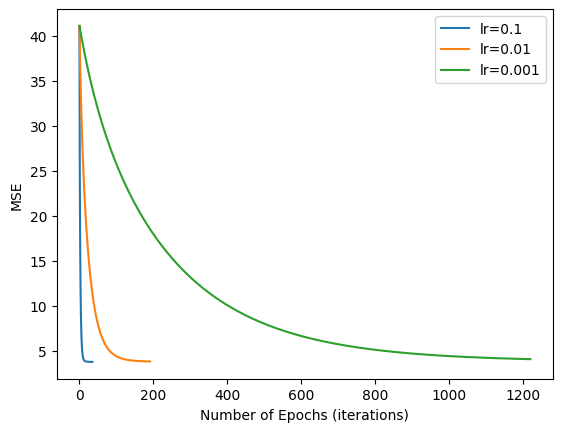

In [ ]:
# Varying learning rate

for i in range(4):

  # Different learning rate
  lr = 10 ** -i
  print('\nLearning Rate ', lr)

  # Model training
  gd_weights, loss_seq = batch_gd(train_X, train_Y_reshaped, lr, T= 3000, e_loss = 1e-3)

  # Computation of MSE on the validation Data
  gd_val_predictions = np.dot(val_X, gd_weights)
  val_MSE = MSE(gd_val_predictions, val_Y)
  print('MSE with validation data: ', round(val_MSE,2))

  # Plots
  if val_MSE < 1e4:
    plt.plot(loss_seq, label = 'lr=' + str(lr))

plt.legend()
plt.xlabel('Number of Epochs (iterations)')
plt.ylabel('MSE')

## Question

Which learning rate leads to the best trainng and validation MSE respectively? Do you observe better training MSE tend to correpsond to better validation MSE? How is this different from the trend shown on page 51 of the lecture slides (titled danger of using training loss to select M) regarding overfitting? Is there any issue with using training loss to pick learning rate in this case?

**Learning rates vs best losses?**

* For the training set, the best MSE was obtained with a lr of **0.1**.
* For the validation set, the best MSE was obtained with a lr of **0.01**

**Do you observer better training MSE ten to correspond to better validation MSE?**
Not necessarily, it didn't happen in this case

**How is this different from the trend shown on page 51**
Slide 51 is about using the training loss to pick the M-th order of the polynominal. However

Slide 51 is about how does the M-th order polynominal affect the fitting as a linear regression. The higher M, the higher the overfitting.




# Part 3. More exploration.

## **3(a). (20 pts) Normalization of features: what is the impact?**
In part 1, you were asked to perform z-score normalization of all the features. In this part, we will ask you to first conceptually think about what is the impact this operation on the solution and then use some experiments to varify your conceptual understanding.

### **Questions.**

The normalization process applies a linear transformation to each feature, where the transformed feature $x'$ is simply a linear function of original feature $x$: $x'=\frac{x-\mu}{\sigma}$.

Let's disect the influence of this transformation on our learned linear regression model.
1. How do you think this transformation will influnce the training and validation MSE we get for the closed-form solution? Why?
2. How do you think this will change the magnitude of the weights of the learned model? Why?
3. How do you think this will change the convergence behavior of the batch gradient descent algorithm? Why?

**Your answer goes here.**

Now please perform the following experiments to verify your answer to the above questions.
1. Apply closed-form solution to data that did not go through the feature normalization step, and report the learned weights and the resulting training and testing MSEs.
2. Apply gradient descent algorithm to data that did not go through the feature normalization step using different learning rate. Note that the learning rate used in previous section will no longer work here. You will need to search for an appropriate learning rate to get some converging behavior. Plot your MSE loss curve as a function of the epochs once you identify a convergent learning rate.
Hint: the learning rate needs to be much, much, much, much, much smaller (think about each much as an order of manitude) than what was used in part 2). Also unless you let it run for a long time, it is unlikely to converge to the same level of loss values. So use a upper bound on the # of iterations so that it won't take forever.

In [ ]:
# Your code goes here

**Questions**

Please revisit the questions above. Does your experiment confirm your expectation?  Can you provide explanations to the observed differences (or lack of differences) between the normalized data and unnormalized data? Based on these observations and your understanding of them, please comment on the benefits of normalizing the input features in learning for linear regressions.


**Your answer goes here**

## **3(b). (20 pts) Explore the impact of correlated features**

In the warm up exercise, you all have seen some features are highly correlated with one another. For example, there are multiple squared footage related features that are strongly correlated (e.g., *sqft_above* and *sqrt_living* has a correlation coefficient of 0.878).  This is referred to as multicollinearity phenomeon, where two or more features are correlated.

There are numerous consequences from multicollinearity. It makes it more challenging to estimate the weights of the features accurately. The weights may become unstable, and their interpretation becomes less clear.

In this part you will work with the pre-processed training set, and perform the following experiments **using the closed-form solution**.
Specifically, your code should:

1. Create five slighly different training sets, each of which is obtained by randomly subsample 75% of the orginial training set.
2. Use the closed-form solution of linear regression to fit the model on each of the five training sets.
3. For each model, report the learned weight vector in a table.
The table should have five rows (one for each model) and a column for each feature’s weight. Include a header row to clearly label the feature names for each column.
4. Compute the variance of the learned weight coefficients across the five models for each feature. This variance will serve as a measure of the **stability** of the weight assigned to each feature.

In [ ]:
# Your code goes here

### **Questions**

Ideally, we would like the weight coefficients to be stable across different runs, as this increases confidence in the model's reliability. Do highly correlated features tend to exhibit more instability in their weights across different training sets compared to less correlated features? Discuss any trend you observe based on the variance of the weight coefficients. How does the stability of these features relate to the multicollinearity issue present in this dataset?


**Your answer goes here.**

# Bonus. In-class competition (5 bonus pts)

We will host a in-class competition using the IA1 data, where you are encouraged to explore different ways to improve the prediction performance by manipunating the data. This could include: feature engineering such as removing, transforming features, constructing new features based on existing ones, using different encoding for the discrete features; data manipulation such as identifying and removing potential outliers; and target manipulation such as log transforming the price target. This is where you can get creative and test your ideas out.

To participate in this competition, use the following link:
https://www.kaggle.com/t/7a885211273e48968e3a5f1b556cb685

You should continue working in the same team for this competition. The training and validation data provided on the kaggle site are the same as the IA1 assignment. To participate, you will need to train your model and apply it to testing data provided on kaggle, and submit prediction files to be scored.

Your scoring will have two parts, the performance on the public leader board as well as the private leader board. The results on the public leader board is visible through out the competition so that you can gauge how well your model is performing in comparison to others. The private leader board shows the final evaluation performance and will be released only once after the competition is closed.

Each team will be allowed to submit 3 final entries to be evaluated. You can use the public leaderboard performance to pick which models to use for your final evaluation entries.

**Assginment of the bonus points:**

**Performance bonus:** the top 3 teams on the **private** leader board will recieve 5 bonus points.

**Participation bonus:** the 5 teams that submitted the most entries (with different performances) will recieve 3 bonus points. Also any team that participated the competition and got non-trivial performance will receive 2 bonus points.

Bonus points are capped at 5.


**Please provide the team name on the kaggle competition here _________.
Leave it blank if you opt not to participate.**

In [ ]:
#running this code block will convert this notebook and its outputs into a pdf report.
!jupyter nbconvert --to html /content/gdrive/MyDrive/Colab\ Notebooks/IA1-2024.ipynb  # you might need to change this path to appropriate value to location your copy of the IA0 notebook

input_html = '/content/gdrive/MyDrive/Colab Notebooks/IA1-2024.html' #you might need to change this path accordingly
output_pdf = '/content/gdrive/MyDrive/Colab Notebooks/IA1output.pdf' #you might need to change this path or name accordingly

# Convert HTML to PDF
pdfkit.from_file(input_html, output_pdf)

# Download the generated PDF
files.download(output_pdf)